In [43]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
# import umap
import umap.umap_ as umap
from collections import defaultdict

from scipy import linalg, spatial
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer, TfidfVectorizer)

from sklearn.utils.extmath import randomized_svd

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [44]:
# importing csv and converting to df
def create_df(filepath):
    df_all_books = pd.read_json(
        filepath,
        lines=True
    )
    # print(df_all_books.head(3))
    return pd.DataFrame(df_all_books[['title','description']])

In [45]:
def missing_vals(df):
    """
    Outputs missing values in dataframe & removes observations with missing values.
    Input:
    Output:
    """
    print(df.isna().sum())
    # removing rows
    df_clean = df.dropna()
    return df_clean

In [46]:
df = create_df(
    '/Users/angky/Cornell/AML/AML-Project/book_best_books_001_015.jl'
)
print(df.head(10))

                         title  \
0             The Hunger Games   
1  Jonathan Livingston Seagull   
2            Lord of the Flies   
3             Romeo and Juliet   
4                     Stardust   
5                 Tao Te Ching   
6  The Hunchback of Notre-Dame   
7      The Things They Carried   
8        Because of Winn-Dixie   
9    Midnight Sun [2008 Draft]   

                                         description  
0  Could you survive on your own in the wild, wit...  
1  This is a story for people who follow their he...  
2  At the dawn of the next world war, a plane cra...  
3  In Romeo and Juliet, Shakespeare creates a vio...  
4  Alternate cover edition can be found hereYoung...  
5  A lucid translation of the well-known Taoist c...  
6  This extraordinary historical French gothic no...  
7  A classic work of American literature that has...  
8  The summer Opal and her father, the preacher, ...  
9  The record for the completed novel can be foun...  


In [47]:
df = missing_vals(df)
df

title          1
description    2
dtype: int64


,title,description
0,The Hunger Games,"Could you survive on your own in the wild, wit..."
1,Jonathan Livingston Seagull,This is a story for people who follow their he...
2,Lord of the Flies,"At the dawn of the next world war, a plane cra..."
3,Romeo and Juliet,"In Romeo and Juliet, Shakespeare creates a vio..."
4,Stardust,Alternate cover edition can be found hereYoung...
...,...,...
1495,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...
1496,The Book Thief,Librarian's note: An alternate cover edition c...
1497,Pride and Prejudice,"Since its immediate success in 1813, Pride and..."
1498,Harry Potter and the Order of the Phoenix,Harry Potter is about to start his fifth year ...


In [48]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load your dataframe here
# df = pd.read_csv('your_dataframe.csv')

# Stop words set
stop_words = set(stopwords.words('english'))

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Strip non-alphabetic characters and convert to lower case
    text = re.sub('[^A-Za-z]+', ' ', text).lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize the remaining tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    # Reconstruct the text from tokens
    return ' '.join(lemmatized_tokens)

# Apply the preprocessing to the description column
df['processed_description'] = df['description'].apply(preprocess_text)

# Show the dataframe
df


[nltk_data] Downloading package stopwords to /Users/angky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/angky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/angky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,title,description,processed_description
0,The Hunger Games,"Could you survive on your own in the wild, wit...",could survive wild every one make sure live se...
1,Jonathan Livingston Seagull,This is a story for people who follow their he...,story people follow heart make rule people get...
2,Lord of the Flies,"At the dawn of the next world war, a plane cra...",dawn next world war plane crash uncharted isla...
3,Romeo and Juliet,"In Romeo and Juliet, Shakespeare creates a vio...",romeo juliet shakespeare creates violent world...
4,Stardust,Alternate cover edition can be found hereYoung...,alternate cover edition found hereyoung tristr...
...,...,...,...
1495,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,unforgettable novel childhood sleepy southern ...
1496,The Book Thief,Librarian's note: An alternate cover edition c...,librarian note alternate cover edition found h...
1497,Pride and Prejudice,"Since its immediate success in 1813, Pride and...",since immediate success pride prejudice remain...
1498,Harry Potter and the Order of the Phoenix,Harry Potter is about to start his fifth year ...,harry potter start fifth year hogwarts school ...


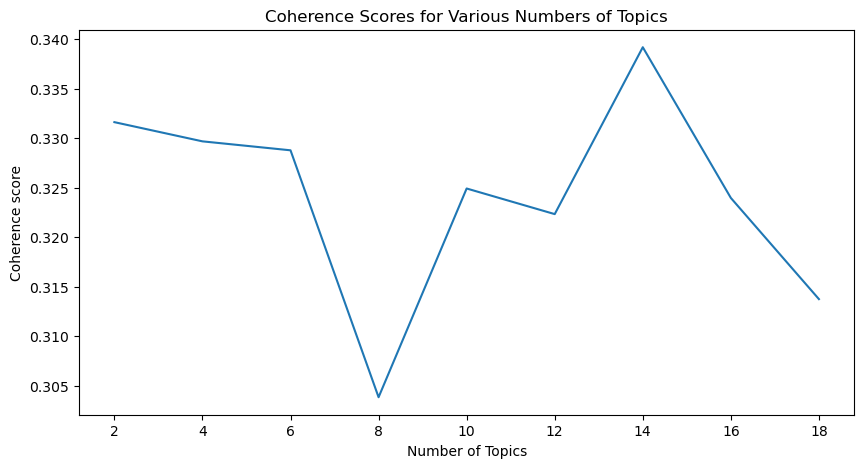

In [53]:
import pandas as pd
from gensim.models import LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt

# Assuming you have a dataframe named 'df'
# df = pd.read_csv('your_dataframe.csv') # Replace with the actual loading code if needed

# Convert the 'processed_description' column into a list of lists of tokens
texts = [desc.split() for desc in df['processed_description']]

# Create a dictionary and corpus
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

corpus = [dictionary.doc2bow(text) for text in texts]

# Define the range of topics to try
topic_nums = list(range(2, 20, 2))

coherence_values = []
model_list = []

for num_topics in topic_nums:
    # Train LDA model
    model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)
    model_list.append(model)
    
    # Compute Coherence Score
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Plotting the coherence scores
plt.figure(figsize=(10, 5))
plt.plot(topic_nums, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Scores for Various Numbers of Topics")
plt.show()


In [55]:
import pandas as pd
from gensim import corpora, models
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
import numpy as np

# Assuming df is your DataFrame and it has a 'processed_description' column
# df = pd.read_csv('your_dataframe.csv') # Replace with your dataframe loading method

# Prepare the text for LDA
texts = [text.split() for text in df['processed_description']]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# Convert dictionary into a bag-of-words format
corpus = [dictionary.doc2bow(text) for text in texts]

# Set parameters for LDA
num_topics = 14  # Adjust the number of topics
passes = 10  # Adequate number of passes through the corpus

# Perform LDA
lda_model = models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)

# Extract topic distribution for documents
topics = lda_model.get_document_topics(corpus, minimum_probability=0)
print(topics)

# Create a matrix of document-topic probabilities
# Ensure every document topic distribution has a probability for each topic
doc_topic_matrix = np.array([[prob for _, prob in doc] for doc in topics])

doc_topic_matrix



array([[9.2786882e-04, 9.2786766e-04, 9.2786638e-04, ..., 4.0680027e-01,
        9.2786446e-04, 9.2786609e-04],
       [1.3741398e-03, 1.3741374e-03, 9.8213625e-01, ..., 1.3741379e-03,
        1.3741305e-03, 1.3741377e-03],
       [1.1343487e-03, 1.1343502e-03, 1.1343465e-03, ..., 1.1343497e-03,
        1.1343478e-03, 1.1343462e-03],
       ...,
       [1.3745761e-03, 1.3745797e-03, 1.3745803e-03, ..., 1.3745776e-03,
        1.3745757e-03, 2.0359899e-01],
       [1.4885415e-03, 4.3566418e-01, 1.4885452e-03, ..., 1.4885468e-03,
        1.4885422e-03, 1.4885416e-03],
       [1.7860419e-03, 1.7860460e-03, 1.7860412e-03, ..., 1.7860534e-03,
        9.7678143e-01, 1.7860404e-03]], dtype=float32)

/Users/angky/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/angky/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/angky/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/angky/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

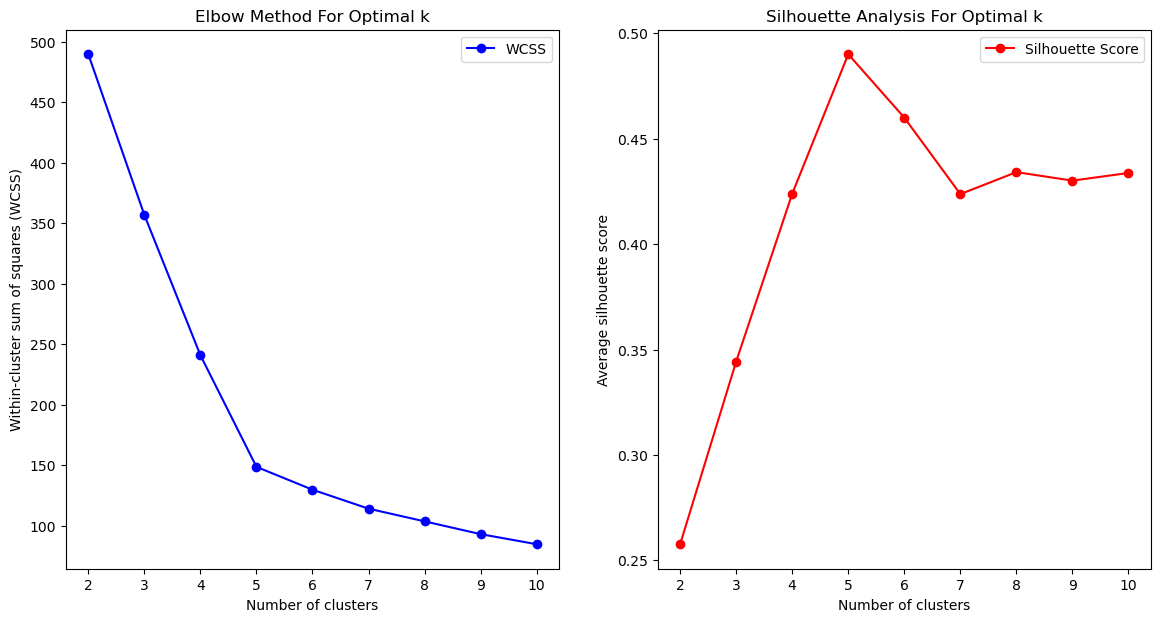

In [50]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming doc_topic_matrix is already defined and is an array-like structure with the document-topic probabilities

# Range of possible clusters to evaluate
range_n_clusters = list(range(2, 11)) # Usually, we start with 2 clusters and go up to 10 or more depending on the data size

# Placeholder for within-cluster sum of squares and silhouette scores
wcss = []
silhouette_avg = []

for n_clusters in range_n_clusters:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(doc_topic_matrix)
    
    # Compute the within-cluster sum of squares
    wcss.append(kmeans.inertia_)
    
    # Compute the silhouette score
    silhouette_avg.append(silhouette_score(doc_topic_matrix, cluster_labels))

# Plotting the elbow method graph
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, wcss, 'bo-', label='WCSS')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.legend()

# Plotting the silhouette analysis graph
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_avg, 'ro-', label='Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette score')
plt.legend()

plt.show()


In [51]:
kmeans = KMeans(n_clusters=5)
df['cluster'] = kmeans.fit_predict(doc_topic_matrix)

# Print the number of books and the first 10 book titles in each cluster
for i in range(5):
    cluster_books = df[df['cluster'] == i]
    num_books_in_cluster = cluster_books.shape[0]
    print(f"\nCluster {i}: {num_books_in_cluster} books")
    titles = cluster_books['title'].head(10).tolist()
    for title in titles:
        print(title)


Cluster 0: 302 books
Romeo and Juliet
The Dispossessed: An Ambiguous Utopia
The Kitchen God's Wife
Die for Me
As You Like It
Pope Joan
Life As We Knew It
The Prime of Miss Jean Brodie
The Book of Negroes
Centennial

Cluster 1: 331 books
Tao Te Ching
The Hunchback of Notre-Dame
The Things They Carried
Midnight Sun [2008 Draft]
Ficciones
"Surely You're Joking, Mr. Feynman!": Adventures of a Curious Character
Take Command: Find Your Inner Strength, Build Enduring Relationships, and Live the Life You Want
Martin Eden
Down and Out in Paris and London
Aesop's Fables

Cluster 2: 404 books
The Hunger Games
Jonathan Livingston Seagull
Stardust
Because of Winn-Dixie
Malibu Rising
Real
Cloudy With a Chance of Meatballs
The Sun Is Also a Star
The Pandarus File
Crash

Cluster 3: 199 books
River God
The Blue Sword
The Traitor's Emblem
The Cuckoo's Calling
Diplomats & Admirals: From Failed Negotiations and Tragic Misjudgments to Powerful Leaders and Heroic Deeds, the Untold Story of the Pacific War 

/Users/angky/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
